# **Import Libraries**



In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

In [2]:
warnings.filterwarnings("ignore")

# **Reading Files**

In [3]:
data_path = '../dataset/trash_images/'

In [4]:
# Data Classes
print(os.listdir(data_path))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [5]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
trash_images,0
cardboard,403
glass,501
metal,410
paper,594
plastic,482
trash,137


In [6]:
print(f'Total {count.sum()}')

Total File Count    2527
dtype: int64


In [7]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

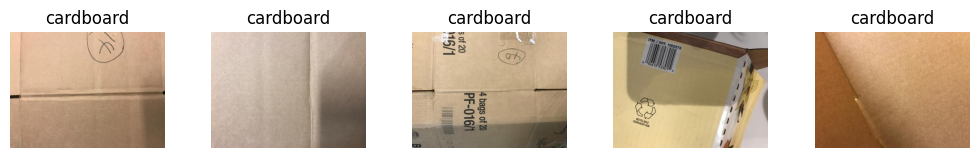

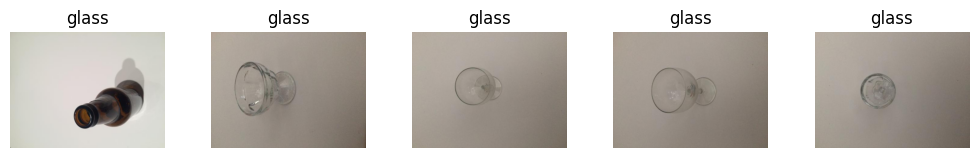

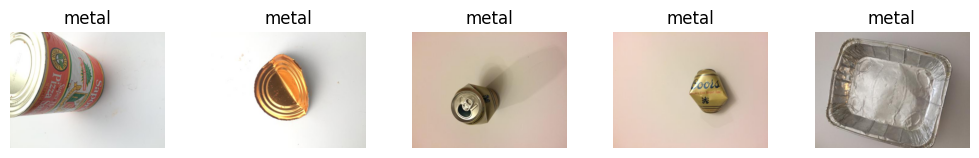

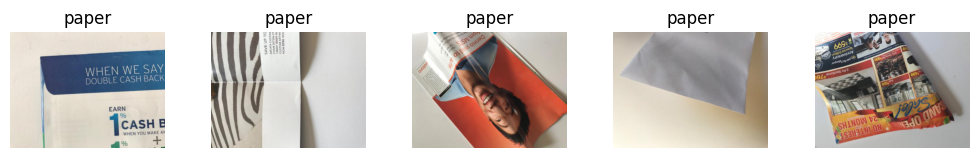

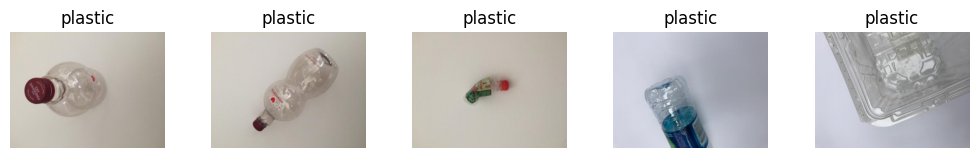

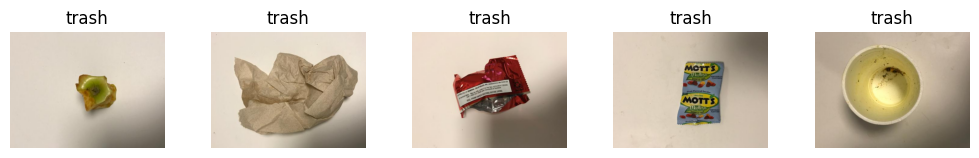

In [8]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

# **Generate Data**

In [9]:
# Define variable for requirements
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [10]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

# **Split Train & Test Files**

In [11]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [12]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


# **Network Architecture**

In [13]:
model = Sequential()
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

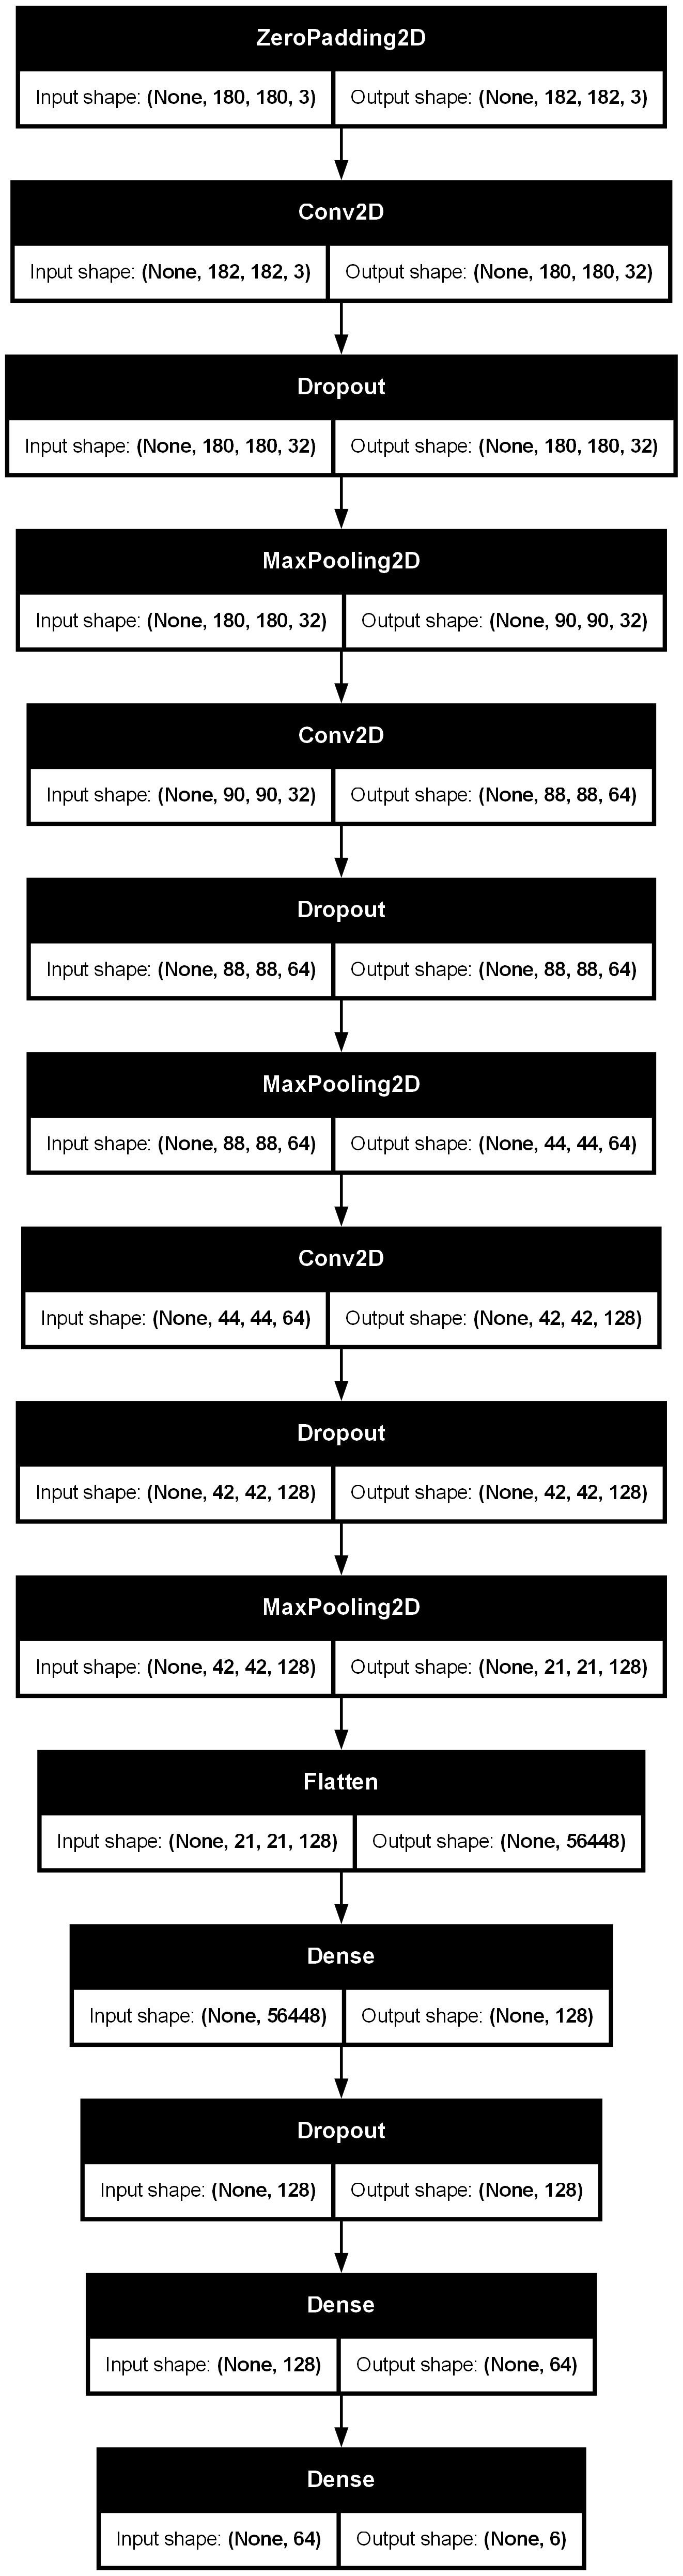

In [14]:
plot_model(model, show_shapes=True, show_layer_names=False)

# **Compiler**

In [15]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [16]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [17]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

# **Train Model**

In [24]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.5963 - loss: 1.0729 - val_categorical_accuracy: 0.5782 - val_loss: 1.2211 - learning_rate: 0.0010
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.5970 - loss: 1.0556

72/72 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - categorical_accuracy: 0.5949 - loss: 1.0766 - val_categorical_accuracy: 0.6048 - val_loss: 1.1364 - learning_rate: 0.0010
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - categorical_accuracy: 0.6102 - loss: 1.0605 - val_categorical_accuracy: 0.5809 - val_loss: 1.1568 - learning_rate: 0.0010
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6216 - loss: 1.0536

72/72 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - categorical_accuracy: 0.6191 - loss: 1.0388 - val_categorical_accuracy: 0.6286 - val_loss: 1.1160 - learning_rate: 0.0010
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6179 - loss: 1.0595

72/72 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - categorical_accuracy: 0.6191 - loss: 1.0528 - val_categorical_accuracy: 0.5995 - val_loss: 1.1101 - learning_rate: 0.0010
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - categorical_accuracy: 0.6149 - loss: 1.0505 - val_categorical_accuracy: 0.6021 - val_loss: 1.1426 - learning_rate: 0.0010
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - categorical_accuracy: 0.6126 - loss: 1.0611 - val_categorical_accuracy: 0.6074 - val_loss: 1.1845 - learning_rate: 0.0010
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - categorical_accuracy: 0.6019 - loss: 1.0386 - val_categorical_accuracy: 0.6286 - val_loss: 1.1433 - learning_rate: 0.0010
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6306 - loss: 0.9880

72/72 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - categorical_accuracy: 0.6256 - loss: 1.0057 - val_categorical_accuracy: 0.6154 - val_loss: 1.0973 - learning_rate: 0.0010
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - categorical_accuracy: 0.6270 - loss: 1.0199 - val_categorical_accuracy: 0.6180 - val_loss: 1.1547 - learning_rate: 0.0010
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - categorical_accuracy: 0.6298 - loss: 1.0047 - val_categorical_accuracy: 0.5756 - val_loss: 1.1665 - learning_rate: 0.0010
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - categorical_accuracy: 0.6576 - loss: 0.9664

72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - categorical_accuracy: 0.6293 - loss: 1.0083 - val_categorical_accuracy: 0.6313 - val_loss: 1.0697 - learning_rate: 0.0010
Epoch 13/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - categorical_accuracy: 0.6340 - loss: 1.0068 - val_categorical_accuracy: 0.6021 - val_loss: 1.1331 - learning_rate: 0.0010
Epoch 14/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - categorical_accuracy: 0.6228 - loss: 1.0238 - val_categorical_accuracy: 0.5517 - val_loss: 1.1817 - learning_rate: 0.0010
Epoch 15/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - categorical_accuracy: 0.6335 - loss: 0.9769 - val_categorical_accuracy: 0.6472 - val_loss: 1.0894 - learning_rate: 0.0010
Epoch 16/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - categorical_accuracy: 0.6353 - loss: 1.0162 - val_categorical_accuracy: 0.5729 - val_loss: 1.1423 - learning_rate: 0.0010
Epoch 17/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.6409 - loss: 0.9826 - val_categorical_accuracy: 0

72/72 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - categorical_accuracy: 0.6465 - loss: 0.9646 - val_categorical_accuracy: 0.6419 - val_loss: 1.0284 - learning_rate: 0.0010
Epoch 20/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.6265 - loss: 1.0079 - val_categorical_accuracy: 0.6260 - val_loss: 1.1040 - learning_rate: 0.0010
Epoch 21/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.6512 - loss: 0.9287 - val_categorical_accuracy: 0.6286 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 22/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - categorical_accuracy: 0.6423 - loss: 0.9464 - val_categorical_accuracy: 0.6499 - val_loss: 1.1035 - learning_rate: 0.0010
Epoch 23/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - categorical_accuracy: 0.6605 - loss: 0.9354 - val_categorical_accuracy: 0.6313 - val_loss: 1.1092 - learning_rate: 0.0010
Epoch 24/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - categorical_accuracy: 0.6460 - loss: 0.9669 - val_categorical_accuracy: 0

72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.6512 - loss: 0.9481 - val_categorical_accuracy: 0.6446 - val_loss: 1.0250 - learning_rate: 0.0010
Epoch 29/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - categorical_accuracy: 0.6330 - loss: 0.9735 - val_categorical_accuracy: 0.6233 - val_loss: 1.0437 - learning_rate: 0.0010
Epoch 30/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.6544 - loss: 0.9365 - val_categorical_accuracy: 0.6446 - val_loss: 1.0707 - learning_rate: 0.0010
Epoch 31/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - categorical_accuracy: 0.6614 - loss: 0.9044 - val_categorical_accuracy: 0.5570 - val_loss: 1.1613 - learning_rate: 0.0010
Epoch 32/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.6632 - loss: 0.9169

72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.6530 - loss: 0.9355 - val_categorical_accuracy: 0.6923 - val_loss: 0.9845 - learning_rate: 0.0010
Epoch 33/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - categorical_accuracy: 0.6726 - loss: 0.8831 - val_categorical_accuracy: 0.6499 - val_loss: 1.0021 - learning_rate: 0.0010
Epoch 34/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - categorical_accuracy: 0.6740 - loss: 0.8810 - val_categorical_accuracy: 0.6552 - val_loss: 1.0163 - learning_rate: 0.0010
Epoch 35/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - categorical_accuracy: 0.6847 - loss: 0.9039 - val_categorical_accuracy: 0.6552 - val_loss: 1.0479 - learning_rate: 0.0010
Epoch 36/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - categorical_accuracy: 0.6702 - loss: 0.9061 - val_categorical_accuracy: 0.5836 - val_loss: 1.0424 - learning_rate: 0.0010
Epoch 37/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - categorical_accuracy: 0.6572 - loss: 0.9272 - val_categorical_accuracy: 0

# **Model Evaluation**

In [25]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.692307710647583


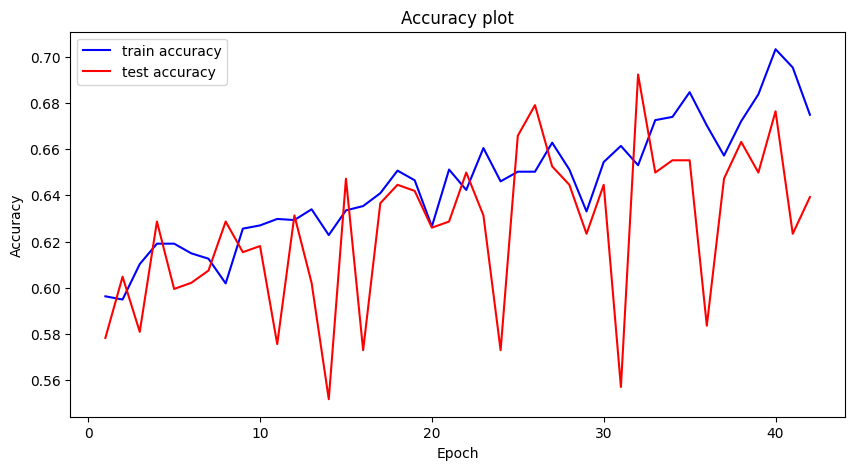

In [26]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

# **Using Model**

In [28]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

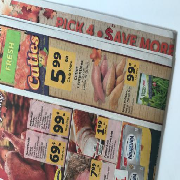

In [30]:
img = utils.load_img(
    '../dataset/trash_images/paper/paper_010.jpg',
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [31]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
paper
